# **Задание Ultra Lite**

1. Перепишите создание свёрточной сети с помощью ГА полностью самостоятельно.

2. Можно взять готовыми лишь некоторые сложные функции.

3. Можно сделать другой формат свёрточной сети, не такой, как в ноутбуке.

4. Можно подсматривать в базовый ноутбук, но не копировать код напрямую.

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Reshape, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MAE
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from PIL import Image
from google.colab import files
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка данных

In [3]:
# Загружаем данные
base_data = pd.read_csv('/content/drive/MyDrive/УИИ/Генетические алгоритмы для обучения нейронных сетей/traff.csv', header=None)

In [4]:
# Проверка
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [4]:
# Возьмем все значения 1 столбца
data = base_data.iloc[:,1]

In [6]:
data

0       22,226.00
1       29,593.00
2       31,726.00
3       32,684.00
4       31,820.00
          ...    
1090    29,801.00
1091    34,913.00
1092    37,665.00
1093    32,643.00
1094    28,212.00
Name: 1, Length: 1095, dtype: object

In [5]:
# Превращаем в numpy массив
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

In [8]:
print(data)
print(data.shape)

[22226.0 29593.0 31726.0 ... 37665.0 32643.0 28212.0]
(1095,)


## Преобразование данных

In [6]:
 xLen = 60                          # Анализируем по 60 прошедшим точкам 
 valLen = 300                       # Используем 300 записей для проверки

 trainLen = data.shape[0] - valLen  # Размер тренировочной выборки

 # Делим данные на тренировочную и тестовую выборки 
 Train = np.reshape(data[:trainLen], (-1,1))
 Test = np.reshape(data[trainLen+xLen+2:], (-1,1))

 print(Train.shape)
 print(Test.shape)

(795, 1)
(238, 1)


In [7]:
# Нормализуем данные
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

print(Train[0])
print(Test[0])

[0.4365639]
[0.17484173]


In [8]:
# Создаем генератор для обучения и теста
trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1, batch_size=20)

testDataGen  = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)

## Функции

In [9]:
# Функция получения выжившей популяции
def getSurvPopul(popul, val, nsurv, reverse=False):
  newpopul = []
  sval = sorted(val, reverse=reverse)
  for i in range(nsurv):
    index = val.index(sval[i])
    #print(index)
    newpopul.append(popul[index])
  return newpopul, sval

In [10]:
# Функция получения родителей
def getParents(curr_popul, nsurv):
  indexp1 = random.randint(0, nsurv - 1)
  indexp2 = random.randint(0, nsurv - 1)
  botp1 = curr_popul[indexp1]
  botp2 = curr_popul[indexp2]
  return botp1, botp2

In [11]:
# Функция смешивания (кроссинговера) двух родителей
def crossPointFrom2Parents(botp1, botp2, j):
  pindex = random.random()
  if pindex < 0.5:
    x = botp1[j]
  else:
    x = botp2[j]
  return x

In [12]:
# Функция результат прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

In [13]:
# Функция визуализации графиков
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значения')
  plt.legend()
  plt.show()

In [14]:
# Функция расёта корреляции
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a * b).mean()
  sa = a.std()
  sb = b.std()
  val = 0
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma * mb) / (sa * sb)
  return val

In [15]:
# Функция отображения корреляцию прогнозированного сигнала с правильным
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=False):
  for ch in channels:
    yLen = yValUnscaled.shape[0]

    corr = []
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, ch]))
    
    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], yValUnscaled[i:, ch]))
    
    if showGraf:
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')
  
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  
  if returnData:
    return corr, own_corr

## Генерируем проверочную выборку

In [16]:
DataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=len(Test))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

print(xVal.shape)
print(yVal.shape)


(1, 178, 60, 1)
(1, 178, 1)


# Подбор линейной архитектуры - Conv2D

In [20]:
# Функция создания списка случайных параметров
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # 0- Нормализация 0,1
  net.append(random.randint(3,6)) # 1- Первый свёрточный слой 2 ** (3,4,5,6) - 8, 16, 32, 64
  net.append(random.randint(3,7)) # 2- Ядро первого свёрточного слоя (3,4,5,6,7)
  net.append(random.randint(0,4)) # 3- Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1)) # 4- MaxPooling 0,1 
  net.append(random.randint(2,3)) # 5- Размер MaxPooling

  net.append(random.randint(0,1)) # 6- Второй сверточный слой 0,1
  net.append(random.randint(3,6)) # 7- Нейроны Conv1d - 8, 16, 32, 64
  net.append(random.randint(3,7)) # 8- Ядро Conv1d - (3,4,5,6,7)
  net.append(random.randint(0,1)) # 9- MaxPooling 0,1 
  net.append(random.randint(2,3)) # 10- Размер MaxPooling
  net.append(random.randint(0,4)) # 11- Функция активации второго слоя Conv2d - ['linear','relu','tanh','softmax','sigmoid']

  net.append(random.randint(0,1)) # 12- Третий сверточный слой 0,1
  net.append(random.randint(3,6)) # 13- Нейроны Conv1d - 8, 16, 32, 64
  net.append(random.randint(3,7)) # 14- Ядро Conv1d - (3,4,5,6,7)
  net.append(random.randint(0,1)) # 15- MaxPooling 0,1 
  net.append(random.randint(2,3)) # 16- Размер MaxPooling
  net.append(random.randint(0,4)) # 17- Функция активации третьего слоя Conv1d - ['linear','relu','tanh','softmax','sigmoid']

  net.append(random.randint(0,4)) # 18- Функция активации предпоследнего Dense слоя  
  net.append(random.randint(0,4)) # 19- Функция активации последнего Dense слоя  

  net.append(random.randint(0,1)) # 20- Финальная нормализация 0,1
  net.append(random.randint(3,6)) # 21- Нейроны в Dense слое - 2 ** (3,4,5,6) - 8, 16, 32, 64

  return net

In [21]:
# Создание архитектуры сети
def createConvNet(net):
  model = Sequential()

  makeFirstNormalization = net[0]   # 0- Нормализация 0,1
  firstConvSize = 2 ** net[1]       # 1- Первый свёрточный слой 2 ** (3,4,5,6) - 8, 16, 32, 64
  firstConvKernel = net[2]          # 2- Ядро первого свёрточного слоя (3,4,5,6,7)
  activation0 = net[3]              # 3- Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  makeMaxPooling0 = net[4]          # 4- MaxPooling 0,1 
  maxPoolingSize0 = net[5]          # 5- Размер MaxPooling

  makeSecondConv = net[6]           # 6- Второй сверточный слой 0,1
  secondConvSize = 2 ** net[7]      # 7- Нейроны Conv1d - 8, 16, 32, 64
  secondConvKernel = net[8]         # 8- Ядро Conv1d - (3,4,5,6,7)
  makeMaxPooling1 = net[9]          # 9- MaxPooling 0,1 
  maxPoolingSize1 = net[10]         # 10- Размер MaxPooling
  activation1 = net[11]             # 11- Функция активации второго слоя Conv2d - ['linear','relu','tanh','softmax','sigmoid']

  makeThirdConv = net[12]           # 12- Третий сверточный слой 0,1
  thirdConvSize = 2 ** net[13]      # 13- Нейроны Conv1d - 8, 16, 32, 64
  thirdConvKernel = net[14]         # 14- Ядро Conv1d - (3,4,5,6,7)
  makeMaxPooling2 = net[15]         # 15- MaxPooling 0,1 
  maxPoolingSize2 = net[16]         # 16- Размер MaxPooling
  activation2 = net[17]             # 17- Функция активации третьего слоя Conv1d - ['linear','relu','tanh','softmax','sigmoid']

  activation3 = net[18]             # 18- Функция активации предпоследнего Dense слоя  
  activation4 = net[19]             # 19- Функция активации последнего Dense слоя

  makeSecondNormalization = net[20] # 20- Финальная нормализация 0,1
  denseSize = 2 ** net[21]          # 21- Нейроны в Dense слое - 2 ** (3,4,5,6) - 8, 16, 32, 64

  activation_list = ['linear', 'relu', 'tanh', 'softmax', 'sigmoid']

  # 0, 1, 2, 3
  if makeFirstNormalization:
    model.add(BatchNormalization(input_shape=(xLen,1)))
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same'))
  else:
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same', input_shape=(xLen,1)))

  # 4,5
  if makeMaxPooling0:
    model.add(MaxPooling1D(pool_size=maxPoolingSize0))

  # 6, 7, 8, 11
  if makeSecondConv:
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same'))

    # 9, 10
    if makeMaxPooling1:
      model.add(MaxPooling1D(pool_size=maxPoolingSize1))

  # 12, 13, 14, 17
  if makeThirdConv:
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same'))

    # 15, 16
    if makeMaxPooling1:
      model.add(MaxPooling1D(pool_size=maxPoolingSize1))
  
  # 20
  if makeSecondNormalization:
    model.add(BatchNormalization())
  
  model.add(Flatten())

  # 18, 21
  model.add(Dense(denseSize, activation=activation_list[activation3]))

  # 19
  model.add(Dense(1, activation=activation_list[activation3]))

  return model

In [22]:
# Функция вычисления результата работы сети
def evaluateNet(net, epochs=10, verb=False):
  val = 0
  #time.time()
  model = createConvNet(net)
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
  history = model.fit(trainDataGen, epochs=epochs, verbose=verb, validation_data=testDataGen)
  val = history.history['val_loss'][-1]
  return val #, model

## Реализация алгоритма

In [37]:
n = 20           # Общее число ботов
nsurv = 10       # Кол-во выживших
nnew = n - nsurv # Кол-во новых
l = 22           # Размер бота
epochs = 15      # Количество эпох

mut = 0.09       # Коэфициент мутаций

In [38]:
popul = []
val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot)
    val.append(f)

  sval = sorted(val, reverse=False)
  end_time = time.time() - curr_time
  print(f'{ep} время: {round(end_time, 2)} ---- Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:5]}')

  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet() 

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

0 время: 76.16 ---- Лучшие результаты: [0.02619820460677147, 0.04174115136265755, 0.04633006080985069, 0.060312047600746155, 0.06831897795200348]  ----- Лучшие боты: [[0, 5, 3, 0, 0, 2, 0, 5, 3, 1, 2, 3, 0, 3, 5, 1, 2, 2, 1, 2, 1, 3], [0, 6, 4, 4, 1, 3, 0, 5, 5, 1, 3, 0, 1, 4, 3, 1, 3, 3, 4, 1, 1, 5], [0, 6, 7, 4, 1, 3, 0, 5, 4, 1, 2, 2, 1, 5, 4, 0, 2, 3, 4, 2, 0, 5], [0, 5, 7, 0, 0, 3, 0, 6, 6, 1, 3, 2, 1, 6, 3, 0, 2, 3, 1, 0, 1, 3], [0, 3, 6, 0, 1, 3, 1, 6, 3, 1, 2, 3, 1, 6, 7, 0, 3, 3, 3, 2, 1, 4]]
1 время: 74.65 ---- Лучшие результаты: [0.029182737693190575, 0.03357774764299393, 0.03480922058224678, 0.038176242262125015, 0.04112524911761284]  ----- Лучшие боты: [[0, 3, 3, 0, 0, 2, 1, 4, 6, 0, 3, 4, 1, 5, 3, 0, 3, 1, 0, 4, 0, 3], [0, 3, 5, 1, 0, 2, 1, 6, 5, 1, 3, 4, 0, 4, 4, 0, 3, 1, 0, 0, 0, 5], [0, 5, 7, 3, 0, 2, 1, 4, 6, 0, 2, 0, 0, 4, 5, 1, 3, 3, 2, 1, 0, 6], [1, 3, 3, 4, 1, 3, 0, 4, 6, 0, 3, 3, 0, 5, 5, 0, 2, 4, 2, 0, 0, 4], [1, 6, 7, 3, 1, 3, 1, 4, 6, 0, 3, 3, 0, 4, 4, 0, 2, 3

In [39]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[0, 6, 7, 2, 0, 2, 1, 6, 3, 0, 2, 2, 0, 5, 4, 0, 3, 2, 0, 4, 0, 5]
[0, 6, 7, 2, 0, 3, 1, 6, 6, 0, 2, 2, 0, 5, 4, 0, 3, 1, 0, 1, 0, 5]
[0, 6, 7, 1, 0, 2, 0, 6, 6, 0, 2, 2, 0, 5, 3, 1, 3, 1, 0, 4, 0, 5]


## Обучение лучшей модели

In [40]:
model = createConvNet(popul[0])

### Архитектура сети

In [41]:
model.summary()

Model: "sequential_501"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_871 (Conv1D)         (None, 60, 64)            512       
                                                                 
 conv1d_872 (Conv1D)         (None, 60, 64)            12352     
                                                                 
 flatten_501 (Flatten)       (None, 3840)              0         
                                                                 
 dense_1002 (Dense)          (None, 32)                122912    
                                                                 
 dense_1003 (Dense)          (None, 1)                 33        
                                                                 
Total params: 135,809
Trainable params: 135,809
Non-trainable params: 0
_________________________________________________________________


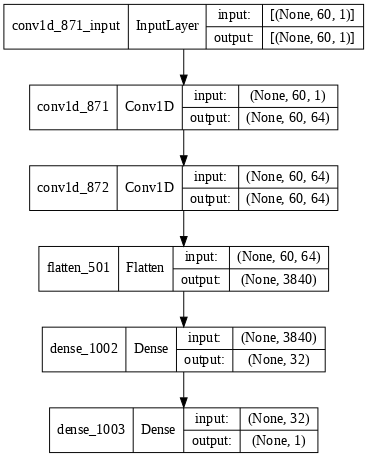

In [42]:
plot_model(model, show_shapes=True, dpi = 70)

### Обучение

In [43]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history = model.fit(trainDataGen, epochs=50, validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 1s 18ms/step - loss: 0.0519 - val_loss: 0.0125
Epoch 2/50
37/37 [==============================] - 1s 15ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 3/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 4/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 5/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/50
37/37 [==============================] - 1s 15ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 10/50
37/37 [==============================] - 1s 14ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 11/

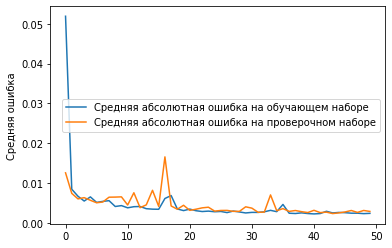

In [44]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

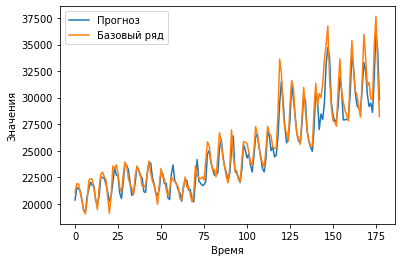

In [45]:
# Прогнозируем данные
currModel = model
predVal, yValUnscaled = getPred(currModel, xVal[0], yVal[0], Scaler)

# Отображение
showPredict(0, 400, 0, predVal, yValUnscaled)

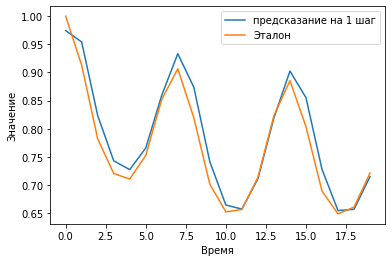

In [46]:
# Корреляция
autoCorr([0], 20, predVal, yValUnscaled)

# Подбор нелинейной архитектуры - Conv1D

In [44]:
xLen = 60                          # Анализируем по 60 прошедшим точкам 
valLen = 300                       # Используем 300 записей для проверки

## Функции

In [45]:
# Функция создания списка случайных параметров
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # 0- Нормализация в начале 0,1
  net.append(random.randint(2,4)) # 1- Ядро MaxPooling 2,3,4 

  net.append(random.randint(3,10)) # 2- Первый Conv1D от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # 3- Ядро первого Conv1D - 3,4,5,6,7
  net.append(random.randint(0,4))  # 4- Функция активации, первого слоя

  net.append(random.randint(0,1))  # 5- Второй слой 0,1
  net.append(random.randint(3,10)) # 6- Второй Conv1D от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # 7- Ядро второго Conv1D - 3,4,5,6,7
  net.append(random.randint(0,1))  # 8- MaxPooling 0, 1
  net.append(random.randint(0,4))  # 9- Функция активации, второго слоя

  net.append(random.randint(0,1))  # 10- Третий слой 0,1
  net.append(random.randint(3,10)) # 11- Третий Conv1D от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # 12- Ядро третьего Conv1D - 3,4,5,6,7
  net.append(random.randint(0,1))  # 13- MaxPooling 0, 1
  net.append(random.randint(0,4))  # 14- Функция активации, третьего слоя

  net.append(random.randint(0,1))  # 15- Четвертый слой 0,1
  net.append(random.randint(3,10)) # 16- Четвертый Conv1D от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # 17- Ядро четвертого Conv1D - 3,4,5,6,7
  net.append(random.randint(0,1))  # 18- MaxPooling 0, 1
  net.append(random.randint(0,4))  # 19- Функция активации, четвертого слоя

  net.append(random.randint(0,1))  # 20- Пятый слой 0,1
  net.append(random.randint(3,10)) # 21- Пятый Conv1D от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # 22- Ядро пятого сConv1D - 3,4,5,6,7
  net.append(random.randint(0,1))  # 23- MaxPooling 0, 1
  net.append(random.randint(0,4))  # 24- Функция активации, пятого слоя

  net.append(random.randint(0,1))  # 25- Dense слой 0,1
  net.append(random.randint(3,10)) # 26- Размер Dense слоя от 8 до 1024
  net.append(random.randint(0,4))  # 27- Функция активации
  
  return net

In [54]:
# Функция создания модели
def createConvNet(net):
  makeFirstNormalization = net[0] # 0- Нормализация в начале 0,1
  maxPoolKernel = net[1]          # 1- Ядро MaxPooling 2,3,4

  firstConvSize = 2 ** net[2]     # 2- Первый Conv1D от 8 до 1024 нейронов
  firstConvKernel = net[3]        # 3- Ядро первого Conv1D - 3,4,5,6,7
  activation1 = net[4]            # 4- Функция активации, первого слоя

  makeConv2 = net[5]              # 5- Второй слой 0,1
  secondConvSize = 2 ** net[6]    # 6- Второй Conv1D от 8 до 1024 нейронов
  secondConvKernel = net[7]       # 7- Ядро второго Conv1D - 3,4,5,6,7
  makePool2 = net[8]              # 8- MaxPooling 0, 1
  activation2 = net[9]            # 9- Функция активации, второго слоя

  makeConv3 = net[10]             # 10- Третий слой 0,1
  thirdConvSize = 2 ** net[11]    # 11- Третий Conv1D от 8 до 1024 нейронов
  thirdConvKernel = net[12]       # 12- Ядро третьего Conv1D - 3,4,5,6,7
  makePool3 = net[13]             # 13- MaxPooling 0, 1
  activation3 = net[14]           # 14- Функция активации, третьего слоя

  makeConv4 = net[15]             # 15- Четвертый слой 0,1
  fourthConvSize = 2 ** net[16]   # 16- Четвертый Conv1D от 8 до 1024 нейронов
  fourthConvKernel = net[17]      # 17- Ядро четвертого Conv1D - 3,4,5,6,7
  makePool4 = net[18]             # 18- MaxPooling 0, 1
  activation4 = net[19]           # 19- Функция активации, четвертого слоя

  makeConv5 = net[20]             # 20- Пятый слой 0,1
  fifthConvSize = 2 ** net[21]    # 21- Пятый Conv1D от 8 до 1024 нейронов
  fifthConvKernel = net[22]       # 22- Ядро пятого сConv1D - 3,4,5,6,7
  makePool5 = net[23]             # 23- MaxPooling 0, 1
  activation5 = net[24]           # 24- Функция активации, пятого слоя
  

  makeDense = net[25]             # 25- Dense слой 0,1
  denseSize = 2 ** net[26]        # 26- Размер Dense слоя от 8 до 1024
  activation6 = net[27]           # 27- Функция активации

  shape = (xLen, 1)
  inputs = Input(shape)         # Входной слой

  activation_list = ['linear', 'relu', 'tanh', 'softmax', 'sigmoid']

  if makeFirstNormalization:
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize, firstConvKernel, padding='same')(x)
    x = Activation(activation_list[activation1])(x)

  else:
    x = Conv1D(firstConvSize, firstConvKernel, padding='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]     # Список для склейки

  for i in range(4):
    if net[5+5*i] != 0:   # 5, 10, 15, 20
      x = Conv1D(net[6+5*i], net[7+5*i], padding='same')(x)    # Нейроны [6+5*i] - 6, 11, 16, 21, Ядро [7+5*i] - 7, 12, 17, 22
      x = Activation(activation_list[net[5*i+4]])(x)           # [5*i+4] - 9, 14, 19, 24
      x = Reshape((-1,1))(x)

      if net[8+5*i] != 0:       # MaxPooling [8+5*i] - 8, 13, 18, 23
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)
      else:
        list_to_concat.append(x)
      
      list_to_concat.append(x)
    
  for i in range(len(list_to_concat)):
    if list_to_concat[i].shape != (None, 0, 1):
      list_to_concat[i] = Flatten()(list_to_concat[i])
    else:
      break
    
  # Соединяем значения списка
  if len(list_to_concat) != 1:
    fin = concatenate(list_to_concat)
  
  # Иначе просто делаем flatten
  else:
    fin = Flatten()(x)

  # Dense
  if makeDense != 0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin)
  return model

In [53]:
# Функция вычисления результата

def evaluateNet(net, ep=10, verb=False):
  val = 0
  model = createConvNet(net)
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
  history = model.fit(trainDataGen, epochs=ep, verbose=verb, validation_data=testDataGen)

  # Прогнозируем данные
  predVal, yValUnscaled = getPred(model, xVal[0], yVal[0], Scaler)

  # Возвращаем автокорреляцию 
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf=False, returnData=True)

  #Считаем MAE и прибавляем ошибку
  val = MAE(corr, own_corr).numpy() + history.history['val_loss'][-1]

  return val, model

## Реализация алгоритма

In [55]:
n = 20           # Общее число ботов
nsurv = 8        # Кол-во выживших
nnew = n - nsurv # Кол-во новых
l = 28           # Размер бота
epochs = 15      # Количество эпох

mut = 0.3        # Коэфициент мутаций

In [56]:
popul = []
val = []

# Создаём ботов
for i in range(n):
  popul.append(createRandomNet())

for ep in range(epochs):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f,model_sum = evaluateNet(bot, 3, 0) 
    val.append(f)
  
  # Сортируем val
  sval = sorted(val, reverse=0)

  # Вывод
  end_time = time.time() - curr_time
  print(f'{ep} время: {round(end_time, 2)} ---- Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:5]}')

  newpopul = []   # Новая популяция
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet() 

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

0 время: 106.85 ---- Лучшие результаты: [0.0935690743877045, 0.11556492204068021, 0.13130346297849554, 0.13468044704206422, 0.13602773318456646]  ----- Лучшие боты: [[1, 4, 3, 6, 0, 0, 5, 7, 1, 3, 1, 9, 4, 1, 4, 0, 7, 4, 1, 3, 0, 7, 7, 1, 4, 0, 6, 0], [1, 4, 8, 6, 0, 0, 4, 7, 1, 0, 0, 5, 7, 0, 0, 1, 4, 4, 1, 1, 0, 3, 3, 0, 0, 1, 4, 4], [0, 3, 9, 7, 4, 0, 8, 6, 0, 0, 0, 3, 4, 0, 3, 0, 9, 7, 1, 0, 1, 4, 7, 1, 2, 0, 8, 0], [0, 4, 6, 3, 2, 1, 8, 5, 1, 4, 1, 7, 7, 0, 4, 0, 4, 4, 1, 3, 1, 8, 5, 0, 1, 0, 5, 0], [1, 2, 4, 3, 0, 1, 4, 7, 0, 4, 0, 5, 4, 1, 4, 1, 4, 5, 0, 2, 1, 9, 4, 1, 1, 1, 9, 0]]
1 время: 59.16 ---- Лучшие результаты: [0.07804596911282835, 0.08134549529264294, 0.09629996447769833, 0.10457489788957774, 0.12058636626959478]  ----- Лучшие боты: [[1, 4, 5, 6, 0, 0, 4, 7, 1, 0, 1, 10, 3, 1, 2, 1, 5, 5, 1, 0, 1, 8, 4, 0, 1, 1, 4, 2], [0, 2, 8, 3, 0, 1, 10, 5, 1, 2, 0, 6, 3, 1, 0, 1, 4, 6, 0, 3, 0, 3, 3, 1, 2, 1, 5, 4], [0, 4, 9, 5, 0, 1, 7, 6, 0, 2, 1, 5, 4, 0, 3, 1, 5, 7, 1, 0, 1, 

## Проверка результатов

In [57]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[0, 3, 3, 3, 2, 1, 8, 5, 0, 1, 0, 8, 6, 1, 2, 0, 7, 5, 1, 0, 1, 3, 6, 1, 3, 1, 6, 2]
[0, 2, 4, 3, 0, 1, 4, 5, 0, 1, 0, 8, 4, 1, 2, 0, 4, 5, 1, 0, 1, 6, 7, 0, 1, 1, 10, 2]
[0, 4, 3, 3, 0, 1, 4, 4, 0, 1, 0, 8, 7, 1, 2, 0, 9, 6, 1, 0, 0, 6, 3, 0, 1, 1, 10, 2]


## Обучение лучшей модели

In [58]:
model = createConvNet(popul[0])

### Архитектура сети

In [59]:
model.summary()

Model: "model_332"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_336 (InputLayer)         [(None, 60, 1)]      0           []                               
                                                                                                  
 conv1d_896 (Conv1D)            (None, 60, 8)        32          ['input_336[0][0]']              
                                                                                                  
 activation_1136 (Activation)   (None, 60, 8)        0           ['conv1d_896[0][0]']             
                                                                                                  
 conv1d_897 (Conv1D)            (None, 60, 8)        328         ['activation_1136[0][0]']        
                                                                                          

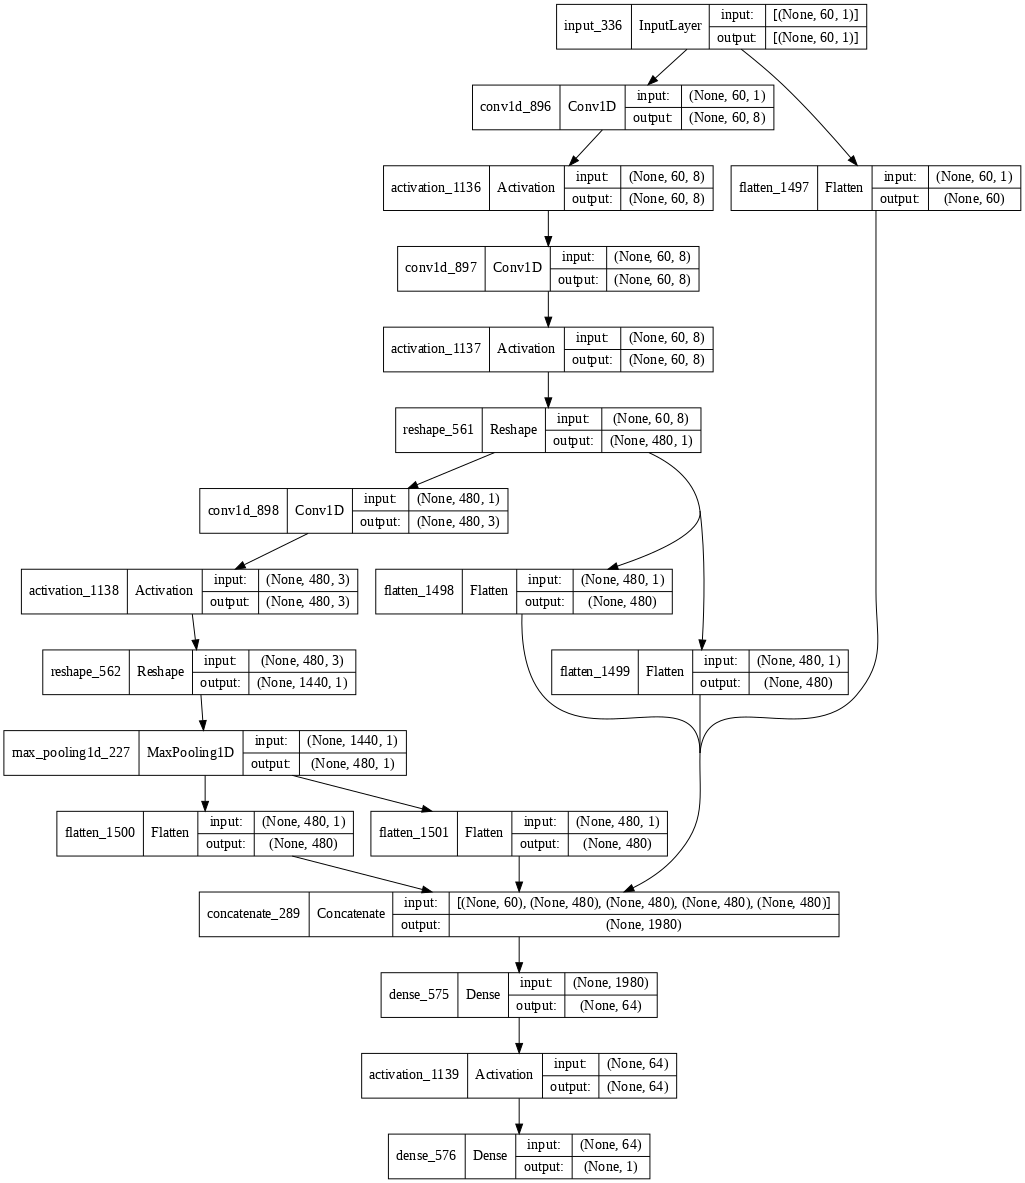

In [60]:
plot_model(model, show_shapes=True, dpi = 70)

### Обучение

In [61]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history = model.fit(trainDataGen, epochs=50, validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 1s 12ms/step - loss: 0.0237 - val_loss: 0.0106
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0137
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0119
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0400
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0068
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 10/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 11/50
37/37 

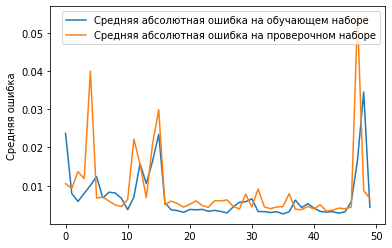

In [62]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

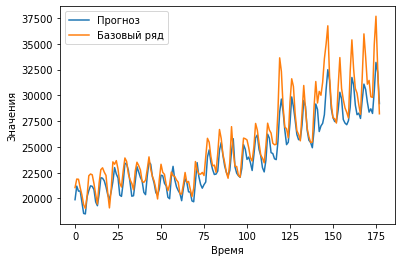

In [63]:
# Прогнозируем данные
currModel = model
predVal, yValUnscaled = getPred(currModel, xVal[0], yVal[0], Scaler)

# Отображение
showPredict(0, 400, 0, predVal, yValUnscaled)

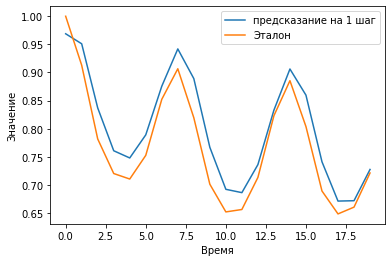

In [64]:
# Корреляция
autoCorr([0], 20, predVal, yValUnscaled)